# **LB_Code_Verification**

---

**Article Title:** Engineering Nonlinear Optical Activation Functions for All-Optical Neural Networks

**Authors:**  
- Xinzhe Xu\* (Purdue University)  
- Ruben Canora\* (Purdue University)  

\*Equal contribution  

**Advisors:** 
- Shengwang Du (Advisor, Purdue University)
- Hadiseh Alaeian (Advisor, Purdue University)  


**Date:** November 2024  
**License:** MIT License

---

## **Objective**

This notebook contains simulations and analysis for the research paper "Engineering Nonlinear Optical Activation Functions for All-Optical Neural Networks Based on Three-Level Atomic Ensemble." Specifically, this notebook focuses on comparing the analytical solution of Electromagnetically Induced Transparency (EIT) under the weak probe approximation and the general numerical solution. The input and output laser intensities of the two lasers are explored.

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.932e-29      # Dipole moment between states |1> and |3> (C·m)
mu_23 = 2.53e-29       # Dipole moment between states |2> and |3> (C·m)
N = 3.5e10             # Atomic number density (atoms/m^3)

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 5/9 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = 4/9 * Gamma3   # Decay from level 3 to level 2 (MHz)
Gamma12 = Gamma21 = 0    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = 0.001 * Gamma3     # Decoherence rate between ground states (MHz)

w_1 = 2 * np.pi * 3e8 / 795e-9
k_0 = w_1 / 3e8
L = 0.1        # Length in meters

### Analytical Solution under Weak Probe Approximation

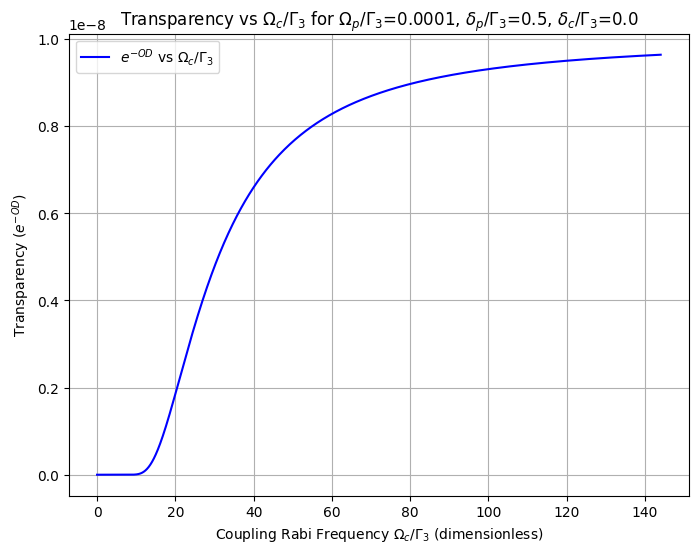

In [9]:
# Backend function to calculate OD based on input
def calculate_OD_1(Om_p=1.0, delta_p=0.0, delta_c=0.0):
    Om_c_list = np.linspace(0.005, 12, 1000)  # Coupling Rabi frequency range (dimensionless)

    # Initialize list to store OD values
    OD_values = []
    T_1_values = []
    Out_Intensities = []

    for Om_c_scaled in Om_c_list:
        Om_c_actual = Om_c_scaled * Gamma3      # Convert to actual Omega_c in MHz
        Om_p_actual = Om_p * Gamma3             # Convert Om_p to MHz
        delta_p_actual = delta_p * Gamma3
        delta_c_actual = delta_c * Gamma3

        numerator = 2 * Om_p_actual * (delta_p_actual - delta_c_actual + 1j * gamma12)
        denominator = (Om_c_actual * np.conj(Om_c_actual) - 4 * (delta_p_actual - delta_c_actual + 1j * gamma12) * (delta_p_actual + 1j * gamma13))
        rho31 = numerator / denominator

        # Calculate chi
        chi = (2 * N * rho31 * mu_13**2) / (epsilon_0 * hbar * Om_p_actual)

        # Calculate OD
        OD = k_0 * np.imag(chi) * L
        OD_values.append(OD)

        # Calculate the transparency
        T_1 = np.exp(-OD)
        T_1_values.append(T_1)

        # the output instensity of the weak probe
        Output_intensity = np.abs(Om_p)**2 * T_1
        Out_Intensities.append(Output_intensity)

    return Om_c_list, OD_values, T_1_values, Out_Intensities

# Function to plot the OD and return the data
def plot_OD(Om_p, delta_p, delta_c):
    Om_c_list, OD_values, T_1_values, Out_Intensities = calculate_OD_1(Om_p, delta_p, delta_c)
    # Plot OD vs Omega_c
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_c_list)**2, Out_Intensities, label='$e^{-OD}$ vs $\Omega_c/\Gamma_3$', color='blue')
    plt.xlabel('Coupling Rabi Frequency $\Omega_c/\Gamma_3$ (dimensionless)')
    plt.ylabel('Transparency ($e^{-OD}$)')
    plt.title(f'Transparency vs $\Omega_c/ \Gamma_3$ for $\Omega_p/\Gamma_3$={Om_p}, $\delta_p/\Gamma_3$={delta_p}, $\delta_c/\Gamma_3$={delta_c}')
    plt.legend()
    plt.grid(True)
    plt.show()
    return Om_c_list, OD_values, T_1_values, Out_Intensities

# Set specific values for Om_p, delta_p, delta_c
Om_p = 0.0001   # Omega_p / Gamma3
delta_p = 0.5  # delta_p / Gamma3
delta_c = 0.0  # delta_c / Gamma3

# Call the plot_OD function and get the data
Om_c_list, OD_values, T_1_values, Analytical_Out_Intensities = plot_OD(Om_p, delta_p, delta_c)

### Numerical solver using the generic formulation

Processing z step 500/2000
Processing z step 1000/2000
Processing z step 1500/2000


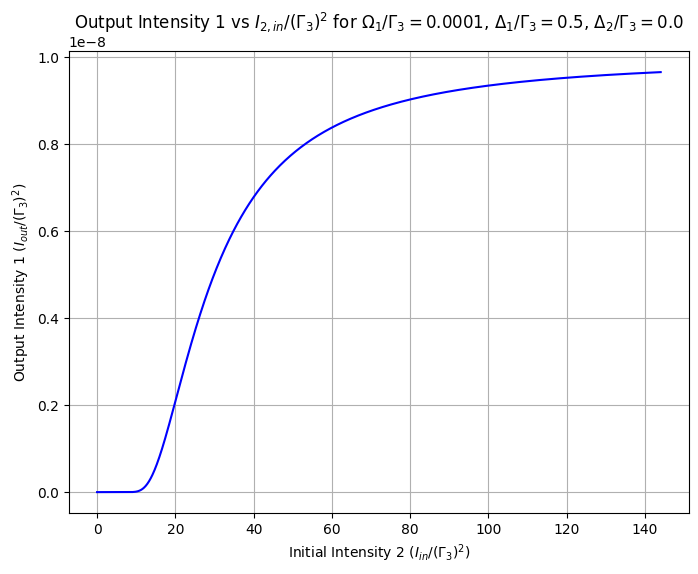

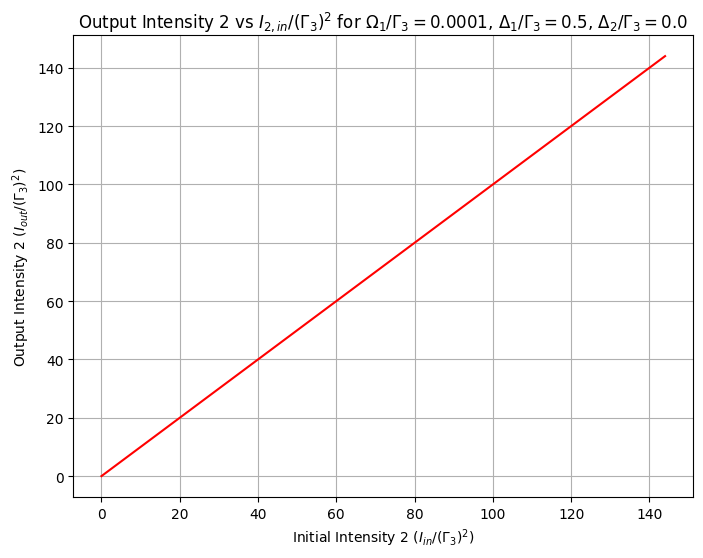

In [11]:
Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_2_list_adapted = None

# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0, z = 0.0001):
    n_rabi = 1000
    Om_2_list_adapted = np.linspace(0.005, 12, n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_2_list = Om_2_list_adapted * Gamma3
    Om_1_list = np.full(n_rabi, Om_1 * Gamma3, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)
    
    # rho11_values[0, :] = 1.0
    # rho22_values[0, :] = 0.0
    # rho33_values[0, :] = 0.0

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(0, len(Om_2_list)):
            Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
            Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

            delta_1_actual = delta_1 * Gamma3
            delta_2_actual = delta_2 * Gamma3

            # Construct A and b as per Code2
            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            try:
                v = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                # Handle singular matrix
                print("nan")
                rho11_values[i][j] = np.nan
                rho22_values[i][j] = np.nan
                rho33_values[i][j] = np.nan
                rho31_values[i][j] = np.nan
                rho32_values[i][j] = np.nan
                continue

            # Extract the solutions
            rho11 = np.real(v[0])
            rho12 = v[1]
            rho13 = v[2]
            rho21 = v[3]
            rho22 = np.real(v[4])
            rho23 = v[5]
            rho31 = v[6]
            rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho11_values[i][j] = np.real(rho11)
            rho22_values[i][j] = np.real(rho22)
            rho33_values[i][j] = np.real(rho33)
            rho31_values[i][j] = rho31
            rho32_values[i][j] = rho32
            

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())
    
    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list_adapted, Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array

def plot_OD(Om_1, delta_1, delta_2, z):
    global Transparency_Omega_1, Transparency_Omega_2, Om_2_list_adapted
    Om_2_list_adapted, Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array = calculate_OD_1(Om_1, delta_1, delta_2, z)
   
    Om_2_vs_z_dimensionless = Om_2_vs_z / Gamma3
    Om_1_vs_z_dimensionless = Om_1_vs_z / Gamma3
    
    # Compute transparency for Omega_1 and Omega_2
    Transparency_Omega_1 = np.abs(Om_1_vs_z[-1, :])**2 / np.abs(Om_1_vs_z[0, :])**2
    Transparency_Omega_2 = np.abs(Om_2_vs_z[-1, :])**2 / np.abs(Om_2_vs_z[0, :])**2

    # Calculate output intensity based on transparency and initial input power
    Output_Intensity_Omega_1 = Transparency_Omega_1 * np.abs(Om_1_vs_z[0, :])**2 / (Gamma3**2)
    Output_Intensity_Omega_2 = Transparency_Omega_2 * np.abs(Om_2_vs_z[0, :])**2 / (Gamma3**2)
    
    # Plot Output Intensity of Omega_1 vs Initial Omega_2
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_2_list_adapted)**2, Output_Intensity_Omega_1, color='blue', label='Output Intensity $\Omega_1$')
    plt.xlabel('Initial Intensity 2 ($I_{in} / (\\Gamma_3)^2$)')
    plt.ylabel('Output Intensity 1 ($I_{out} / (\\Gamma_3)^2$)')
    plt.title(f'Output Intensity 1 vs $I_{{2,\t{{in}}}} / (\\Gamma_3)^2$ for 'f'$\\Omega_1/\\Gamma_3={Om_1}$, 'f'$\\Delta_1/\\Gamma_3={delta_1}$, 'f'$\\Delta_2/\\Gamma_3={delta_2}$')
    plt.grid(True)
    plt.show()

    # Plot Output Intensity of Omega_2 vs Initial Omega_2
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_2_list_adapted)**2, Output_Intensity_Omega_2, color='red', label='Output Intensity $\Omega_2$')
    plt.xlabel('Initial Intensity 2 ($I_{in} / (\\Gamma_3)^2$)')
    plt.ylabel('Output Intensity 2 ($I_{out} / (\\Gamma_3)^2$)')
    plt.title(f'Output Intensity 2 vs $I_{{2,\t{{in}}}} / (\\Gamma_3)^2$ for 'f'$\\Omega_1/\\Gamma_3={Om_1}$, 'f'$\\Delta_1/\\Gamma_3={delta_1}$, 'f'$\\Delta_2/\\Gamma_3={delta_2}$')
    plt.grid(True)
    plt.show()

    Om2_List = np.real(Om_2_list_adapted)**2

    return Om2_List, Output_Intensity_Omega_1

# Function to be triggered when the button is clicked
Om_1 = 0.0001
delta_1 = 0.5
delta_2 = 0.0

# Call the plot_OD function with these values
Om2_List, Numerical_Output_Intensity_1 = plot_OD(Om_1, delta_1, delta_2, 0.00005)

### Exploring the effect of the different step size in the numerical solver

Mean Percent Error: 880.1967246070989%


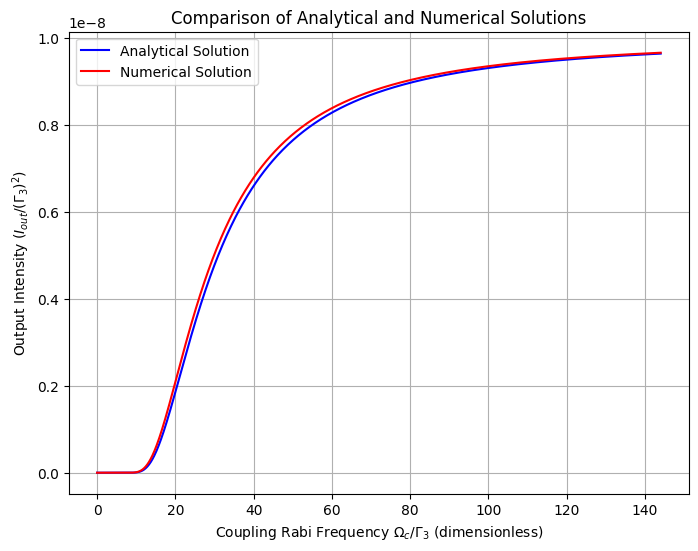

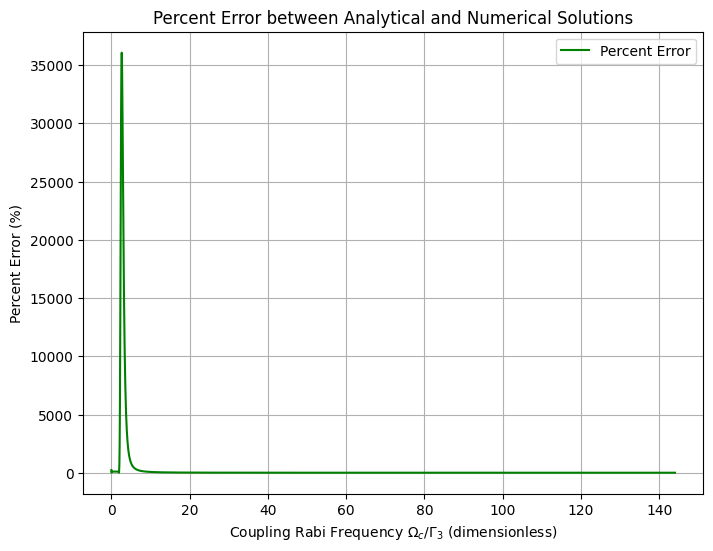

In [ ]:
# Ensure both lists are NumPy arrays
Om_c_list = np.array(Om_c_list)
Om_2_list_adapted = np.array(Om_2_list_adapted)

# Compare the values of Om_c_list and Om_2_list_adapted
assert np.allclose(Om_c_list, Om_2_list_adapted), "The values of Om_c_list and Om_2_list_adapted are not the same."

# Ensure both lists are NumPy arrays
Analytical_Out_Intensities = np.array(Analytical_Out_Intensities)
Numerical_Output_Intensity_1 = np.array(Numerical_Output_Intensity_1)

# Calculate the Percent Error
percent_error = np.abs((Analytical_Out_Intensities - Numerical_Output_Intensity_1) / Analytical_Out_Intensities) * 100
mean_percent_error = np.mean(percent_error)
print(f"Mean Percent Error: {mean_percent_error}%")

# print(percent_error)

# Generate the plot comparing the analytical and numerical solutions
plt.figure(figsize=(8, 6))
plt.plot(np.real(Om_c_list)**2, Analytical_Out_Intensities, label='Analytical Solution', color='blue')
plt.plot(np.real(Om_2_list_adapted)**2, Numerical_Output_Intensity_1, label='Numerical Solution', color='red')
plt.xlabel('Coupling Rabi Frequency $\Omega_c/\Gamma_3$ (dimensionless)')
plt.ylabel('Output Intensity ($I_{out} / (\Gamma_3)^2$)')
plt.title('Comparison of Analytical and Numerical Solutions')
plt.legend()
plt.grid(True)
plt.show()

# Plot the percent error
plt.figure(figsize=(8, 6))
plt.plot(np.real(Om_c_list)**2, percent_error, label='Percent Error', color='green')
plt.xlabel('Coupling Rabi Frequency $\Omega_c/\Gamma_3$ (dimensionless)')
plt.ylabel('Percent Error (%)')
plt.title('Percent Error between Analytical and Numerical Solutions')
plt.legend()
plt.grid(True)
plt.show()

Processing z step 50/200
Processing z step 100/200
Processing z step 150/200


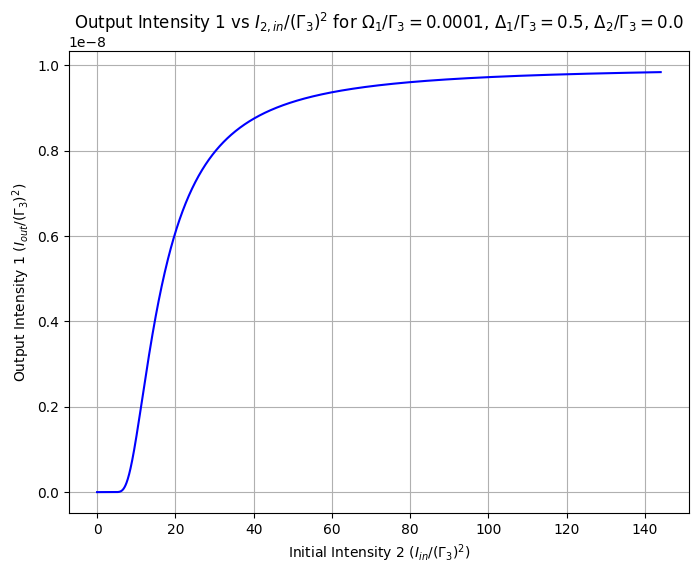

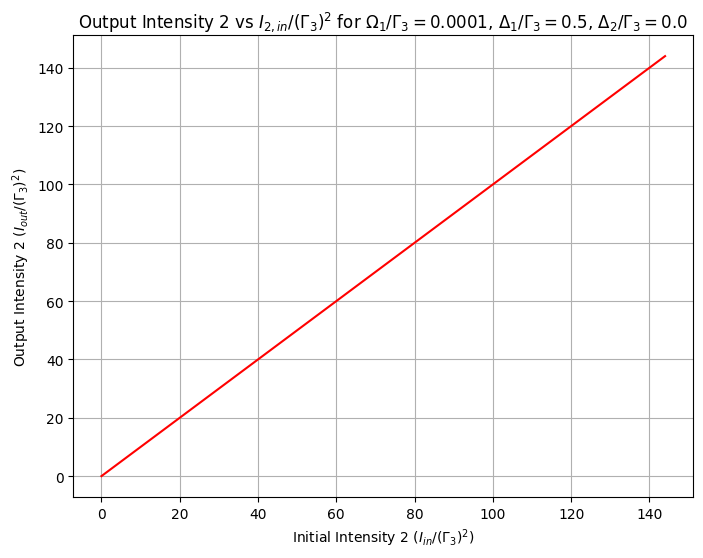

Mean Percent Error for z = 0.0005: 2.03675531404622e+123%
Processing z step 250/1000
Processing z step 500/1000
Processing z step 750/1000


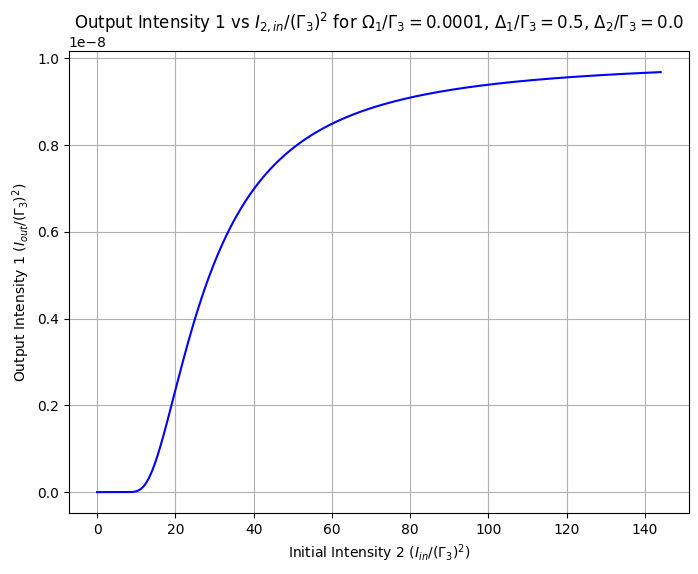

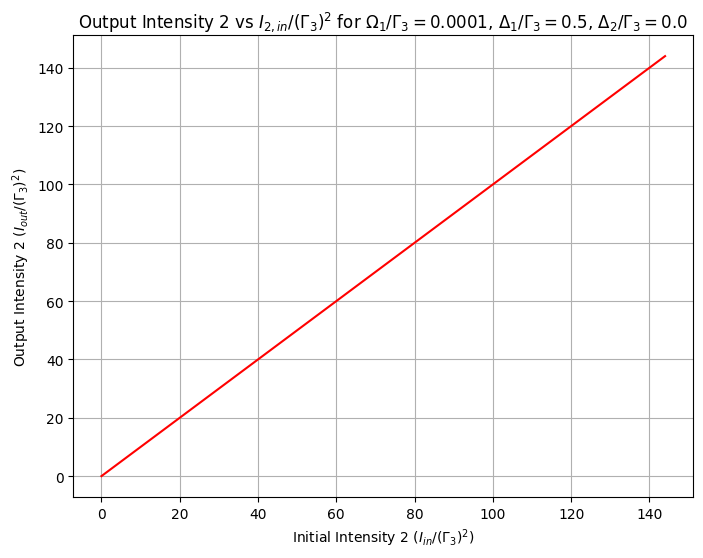

Mean Percent Error for z = 0.0001: 714084.6735226235%
Processing z step 500/2000
Processing z step 1000/2000
Processing z step 1500/2000


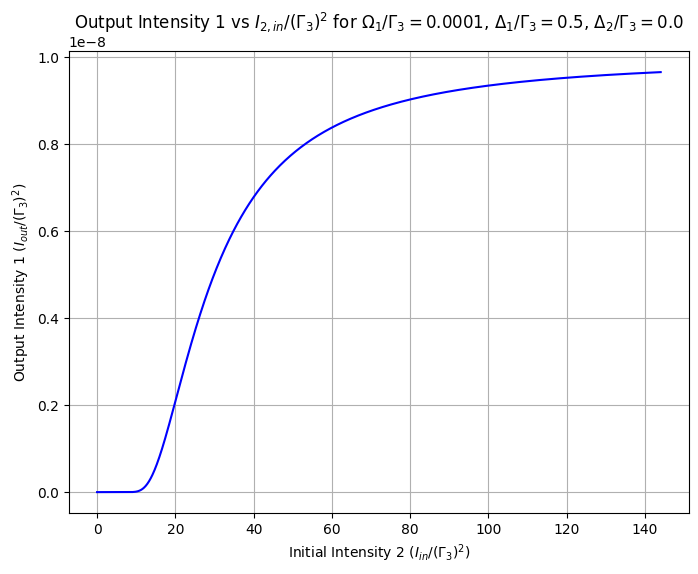

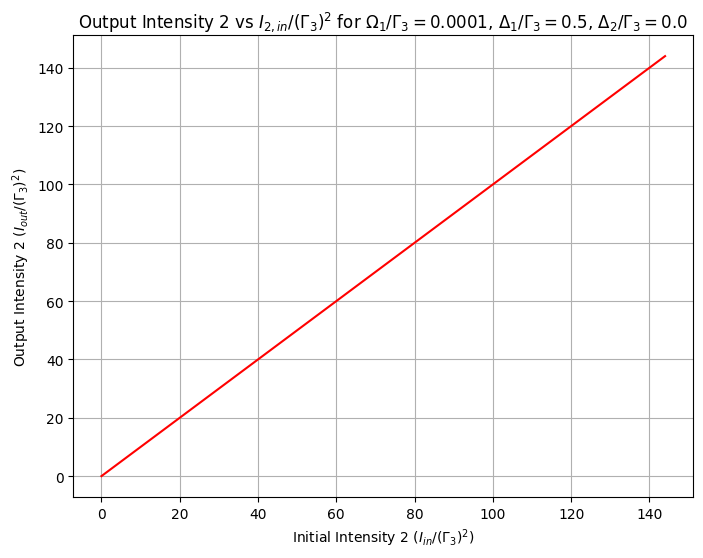

Mean Percent Error for z = 5e-05: 880.1967246070989%
Processing z step 2500/10000
Processing z step 5000/10000
Processing z step 7500/10000


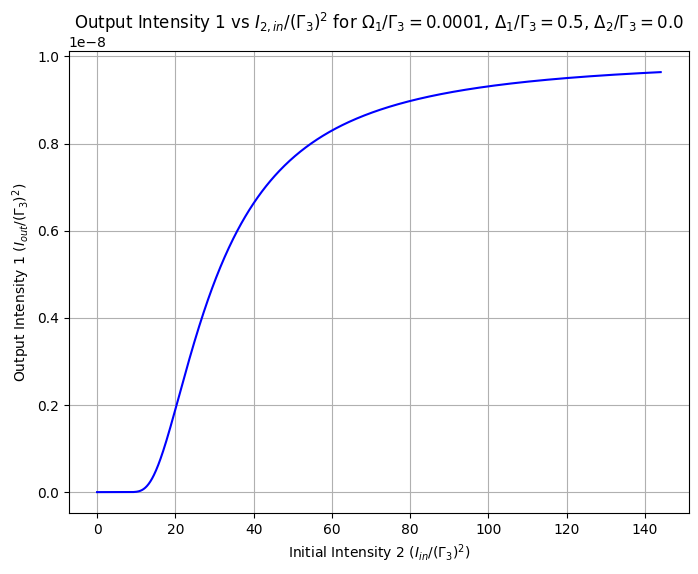

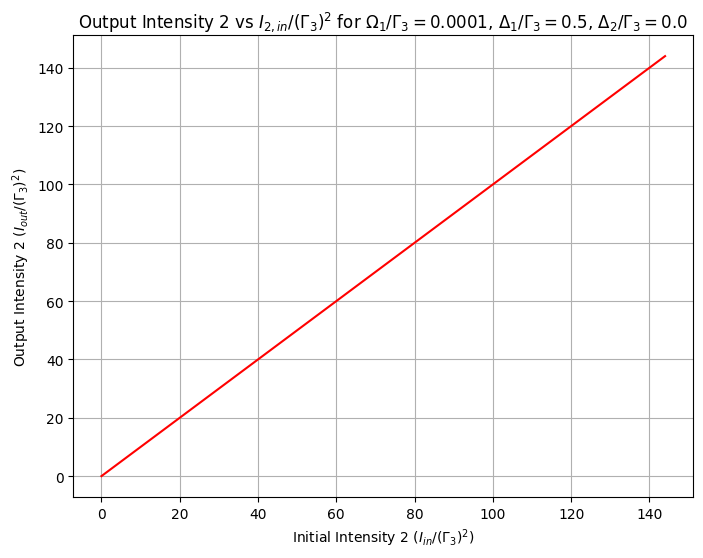

Mean Percent Error for z = 1e-05: 19.44737641764499%
Processing z step 5000/20000
Processing z step 10000/20000
Processing z step 15000/20000


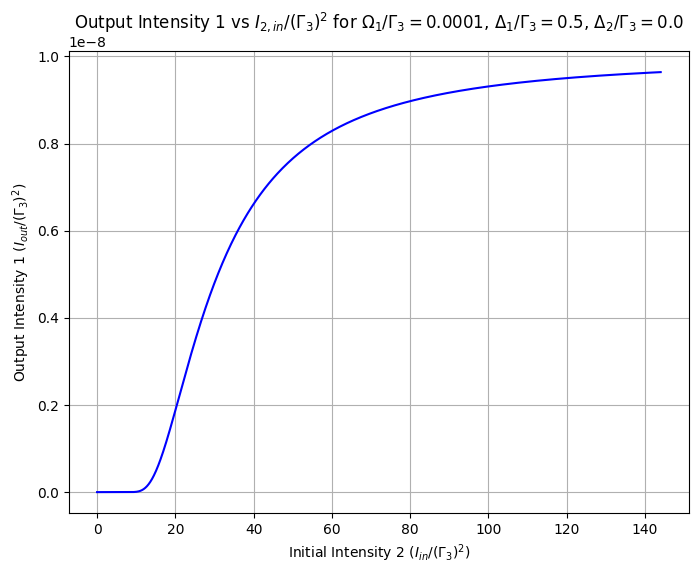

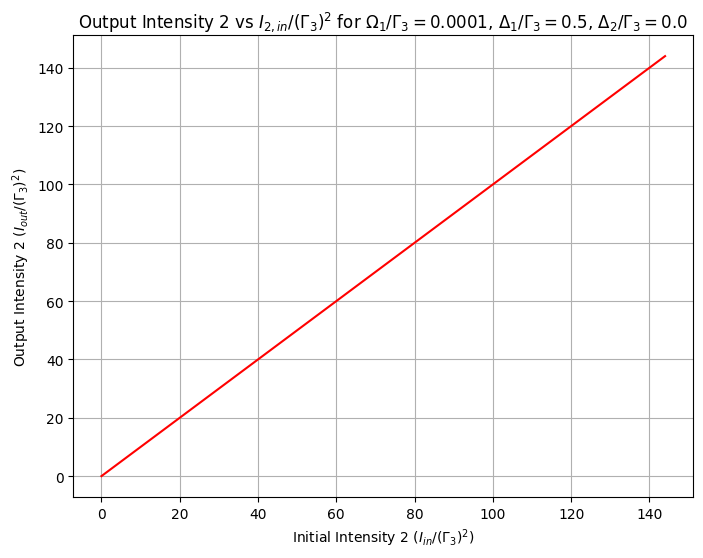

Mean Percent Error for z = 5e-06: 11.546137037929105%


KeyboardInterrupt: 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
# Define the z values to iterate over
z_values = [0.0005, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001]  # Different step sizes to evaluate
errors_for_different_z = []  # To store errors for each z value

# Loop over different z values
for z in z_values:
    # Compute numerical output intensities with the current step size z
    _, Numerical_Output_Intensity_1 = plot_OD(Om_1, delta_1, delta_2, z)

    # Calculate the percent error between analytical and numerical solutions
    percent_error = np.abs((Analytical_Out_Intensities - Numerical_Output_Intensity_1) / Analytical_Out_Intensities) * 100
    errors_for_different_z.append(percent_error)

    # Print the mean percent error for the current z value
    mean_percent_error = np.mean(percent_error)
    print(f"Mean Percent Error for z = {z}: {mean_percent_error}%")

# Plotting all percent errors for each z value on the same graph
plt.figure(figsize=(10, 6))

for idx, z in enumerate(z_values):
    plt.plot(np.real(Om_c_list)**2, errors_for_different_z[idx], label=f'z = {z}')

plt.xlabel('Coupling Rabi Frequency $\\Omega_c/\\Gamma_3$ (dimensionless)')
plt.ylabel('Percent Error (%)')
plt.title('Percent Error between Analytical and Numerical Solutions for Different Step Sizes')
plt.yscale('log')  # Set y-axis to log scale
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()